# Julia for Data Analysis

## Bogumił Kamiński

# Lecture 14. Creating web services for sharing data analysis results

## Pricing financial options using Monte Carlo simulation

### Calculation of asian option payoff

In [1]:
using Plots
using Statistics
X = [1.0, 1.1, 1.3, 1.2, 1.2]

5-element Vector{Float64}:
 1.0
 1.1
 1.3
 1.2
 1.2

In [2]:
T = 1.0
m = 4
Y = mean(X)

1.1600000000000001

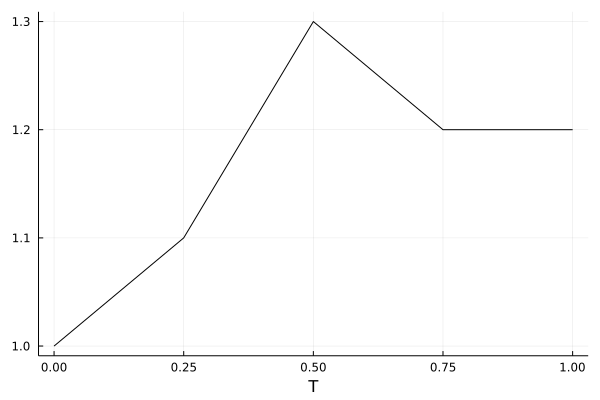

In [3]:
K = 1.05
plot(range(0.0, T; length=m+1), X; xlabel="T", legend=false, color="black")

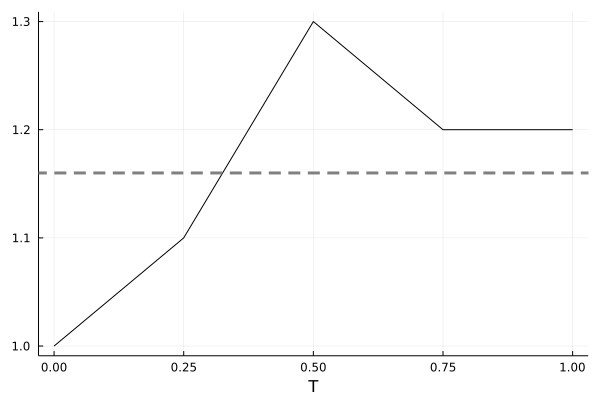

In [4]:
hline!([Y], color="gray", lw=3, ls=:dash)

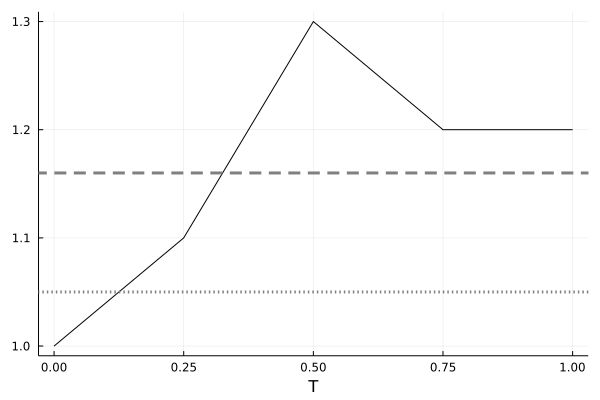

In [5]:
hline!([K], color="gray", lw=3, ls=:dot)

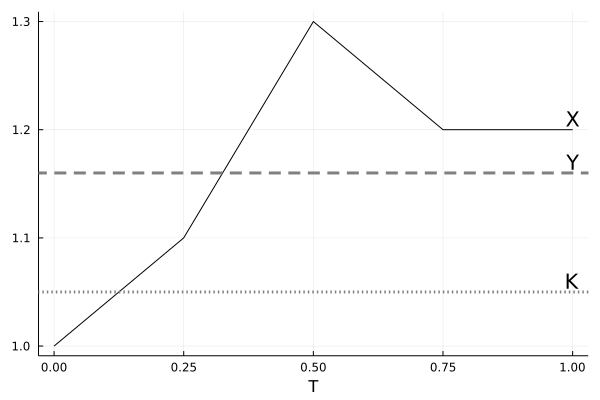

In [6]:
annotate!([(T, Y + 0.01, "Y"),
(T, K + 0.01, "K"),
(T, X[end] + 0.01, "X")])

### Simulating Geometric Brownian Motion (GBM)

In [7]:
using DataFrames
using Random
Random.seed!(1234)
X0, T, s, r, m = 1.0, 2.0, 0.2, 0.1, 4

(1.0, 2.0, 0.2, 0.1, 4)

In [8]:
gbm = DataFrame(X=X0, t=0.0)

,X,t
,Float64,Float64
1,1.0,0.0


In [9]:
for i in 1:m
    Z = randn()
    log_return = (r - s^2/2) * T/m + s * sqrt(T/m) * Z
    next_X = gbm.X[end] * exp(log_return)
    next_t = gbm.t[end] + T/m
    push!(gbm, (next_X, next_t))
end 

In [10]:
gbm

,X,t
,Float64,Float64
1,1.0,0.0
2,0.989186,0.5
3,1.20067,1.0
4,1.17768,1.5
5,1.35691,2.0


## Implementing the option pricing simulator

Note! If the command below shows 1 it means that your Jupyter Notebook for Julia was set up to use 1 thread (this is the default).

If you want to change it you need to add additional Julia kernels to your Jupyter Notebook configuration, as is explained [here](https://julialang.github.io/IJulia.jl/dev/manual/installation/#Installing-additional-Julia-kernels).

Alternatively, if you want to check the performance on multiple threads, you may run the codes for lecture 14 presented in the root folder of this repository in Julia REPL.

In [11]:
Threads.nthreads()

1

### Computing the option payoff for a single sample of stock prices

In [12]:
function payoff_asian_sample(T, X0, K, r, s, m)::Float64
    X = X0
    sumX = X
    d = T / m
    for i in 1:m
        X *= exp((r - s^2 / 2) * d + s * sqrt(d) * randn())
        sumX += X
    end
    Y = sumX / (m + 1)
    return exp(-r * T) * max(Y - K, 0)
end

payoff_asian_sample (generic function with 1 method)

In [13]:
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200)

6.020577079320393

In [14]:
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200)

0.0

In [15]:
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200)

5.888914692969237

In [16]:
using BenchmarkTools
@btime map(i -> payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200), 1:10_000);

  20.420 ms (2 allocations: 78.17 KiB)


We can run this simulation faster by using multi-threading (you will only see the speedup if you started your Jupyer Notebook with more than 1 thread).

In [17]:
using ThreadsX
@btime ThreadsX.map(i -> payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200), 1:10_000);

  21.211 ms (102 allocations: 648.30 KiB)


### Computing the option value

In [18]:
using Statistics
function asian_value(T, X0, K, r, s, m, max_time)
    result = Float64[]
    start_time = time()
    while time() - start_time < max_time
        append!(result, ThreadsX.map(i -> payoff_asian_sample(T, X0, K, r, s, m), 1:10_000))
    end
    n = length(result)
    mv = mean(result)
    sdv = std(result)
    lo95 = mv - 1.96 * sdv / sqrt(n)
    hi95 = mv + 1.96 * sdv / sqrt(n)
    zero = mean(==(0), result)
    return (; n, mv, lo95, hi95, zero)
end

asian_value (generic function with 1 method)

In [19]:
mean(x -> x ^ 2, 1:5)

11.0

### Partial function application syntax

In [20]:
eq0 = ==(0)

(::Base.Fix2{typeof(==), Int64}) (generic function with 1 method)

In [21]:
eq0(1)

false

In [22]:
eq0(0)

true

### Convenient syntax for creation of named tuples

In [23]:
val1 = 10

10

In [24]:
val2 = "x"

"x"

In [25]:
(; val1, val2)

(val1 = 10, val2 = "x")

### Testing asian option valuation function

In [26]:
@time asian_value(1.0, 50.0, 55.0, 0.05, 0.3, 200, 0.25)

  0.255367 seconds (7.50 k allocations: 7.882 MiB, 19.46% compilation time)


(n = 90000, mv = 2.001117124128643, lo95 = 1.9722798972002502, hi95 = 2.0299543510570364, zero = 0.6951111111111111)

In [27]:
@time asian_value(1.0, 50.0, 55.0, 0.05, 0.3, 200, 0.25)

  0.258535 seconds (1.15 k allocations: 8.796 MiB, 4.61% gc time)


(n = 110000, mv = 2.025937387672139, lo95 = 1.9994779788368555, hi95 = 2.052396796507423, zero = 0.6938090909090909)

In [28]:
@time asian_value(1.0, 50.0, 55.0, 0.05, 0.3, 200, 0.25)

  0.250729 seconds (1.16 k allocations: 8.796 MiB)


(n = 110000, mv = 2.0075059177368164, lo95 = 1.9813891837069437, hi95 = 2.0336226517666893, zero = 0.6959181818181818)

## Creating a web service serving the Asian option valuation

In [29]:
using Genie
Genie.Renderer.Json.json((firstname="Bogumił", lastname="Kamiński"))

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=utf-8

{"firstname":"Bogumił","lastname":"Kamiński"}"""

### Running the web servise

Execute the following command in terminal in the root folder of this project to start the server:

## Using the Asian option pricing web service

### Sending a single request to the web service

In [30]:
using HTTP
using JSON3
req = HTTP.post("http://127.0.0.1:8000",
                ["Content-Type" => "application/json"],
                JSON3.write((K=55.0, max_time=0.25)))

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=utf-8
Server: Genie/Julia/1.7.3
Transfer-Encoding: chunked

{"status":"OK","value":{"n":100000,"mv":2.0432727593890974,"lo95":2.0154948777287345,"hi95":2.0710506410494602,"zero":0.69157}}"""

In [31]:
JSON3.write((K=55.0, max_time=0.25))

"{\"K\":55.0,\"max_time\":0.25}"

In [32]:
HTTP.post("http://127.0.0.1:8000", ["Content-Type" => "application/json"], JSON3.write((K="", max_time=0.25)))

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=utf-8
Server: Genie/Julia/1.7.3
Transfer-Encoding: chunked

{"status":"ERROR","value":""}"""

### Collecting responses to multiple requests from a web service in a data frame

In [33]:
using DataFrames
df = DataFrame(K=30:2:80, max_time=0.25)

,K,max_time
,Int64,Float64
1,30,0.25
2,32,0.25
3,34,0.25
4,36,0.25
5,38,0.25
6,40,0.25
7,42,0.25
8,44,0.25
9,46,0.25


In [34]:
df.data = map(df.K, df.max_time) do K, max_time
    @show K
    @time req = HTTP.post("http://127.0.0.1:8000",
                          ["Content-Type" => "application/json"],
                          JSON3.write((;K, max_time)))
    return JSON3.read(req.body)
end;

K = 30
  0.269950 seconds (324 allocations: 21.812 KiB)
K = 32
  0.263516 seconds (321 allocations: 20.953 KiB)
K = 34
  0.266615 seconds (325 allocations: 21.594 KiB)
K = 36
  0.270577 seconds (317 allocations: 21.406 KiB)
K = 38
  0.267997 seconds (324 allocations: 21.328 KiB)
K = 40
  0.280556 seconds (327 allocations: 21.391 KiB)
K = 42
  0.284866 seconds (319 allocations: 21.188 KiB)
K = 44
  0.296282 seconds (325 allocations: 21.625 KiB)
K = 46
  0.294961 seconds (320 allocations: 21.484 KiB)
K = 48
  0.276326 seconds (330 allocations: 21.688 KiB)
K = 50
  0.282773 seconds (505 allocations: 32.203 KiB, 1.22% compilation time)
K = 52
  0.266799 seconds (319 allocations: 21.188 KiB)
K = 54
  0.286451 seconds (323 allocations: 21.531 KiB)
K = 56
  0.280026 seconds (328 allocations: 21.688 KiB)
K = 58
  0.283821 seconds (313 allocations: 21.047 KiB)
K = 60
  0.270013 seconds (341 allocations: 21.672 KiB)
K = 62
  0.283488 seconds (317 allocations: 21.125 KiB)
K = 64
  0.273023 second

In [35]:
df

,K,max_time,data
,Int64,Float64,Object…
1,30,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 390000,\n ""mv"": 20.2147,\n ""lo95"": 20.1877,\n ""hi95"": 20.2417,\n ""zero"": 0.000833333\n }\n}"
2,32,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 370000,\n ""mv"": 18.3459,\n ""lo95"": 18.3182,\n ""hi95"": 18.3736,\n ""zero"": 0.00296486\n }\n}"
3,34,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 360000,\n ""mv"": 16.4396,\n ""lo95"": 16.4117,\n ""hi95"": 16.4676,\n ""zero"": 0.00923056\n }\n}"
4,36,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 330000,\n ""mv"": 14.5826,\n ""lo95"": 14.5536,\n ""hi95"": 14.6117,\n ""zero"": 0.0222182\n }\n}"
5,38,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 360000,\n ""mv"": 12.7441,\n ""lo95"": 12.7167,\n ""hi95"": 12.7715,\n ""zero"": 0.0463444\n }\n}"
6,40,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 350000,\n ""mv"": 10.9472,\n ""lo95"": 10.92,\n ""hi95"": 10.9744,\n ""zero"": 0.0856686\n }\n}"
7,42,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 350000,\n ""mv"": 9.26453,\n ""lo95"": 9.23817,\n ""hi95"": 9.2909,\n ""zero"": 0.142803\n }\n}"
8,44,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 310000,\n ""mv"": 7.72666,\n ""lo95"": 7.6999,\n ""hi95"": 7.75342,\n ""zero"": 0.21451\n }\n}"
9,46,0.25,"{\n ""status"": ""OK"",\n ""value"": {\n ""n"": 310000,\n ""mv"": 6.27526,\n ""lo95"": 6.25015,\n ""hi95"": 6.30037,\n ""zero"": 0.300323\n }\n}"


In [36]:
all(x -> x.status == "OK", df.data)

true

### Unnesting a column of a data frame

In [37]:
small_df = DataFrame(x=[(a=1, b=2), (a=3, b=4), (a=5, b=6)])

,x
,NamedTup…
1,"(a = 1, b = 2)"
2,"(a = 3, b = 4)"
3,"(a = 5, b = 6)"


In [38]:
transform(small_df, :x => identity => AsTable)

,x,a,b
,NamedTup…,Int64,Int64
1,"(a = 1, b = 2)",1,2
2,"(a = 3, b = 4)",3,4
3,"(a = 5, b = 6)",5,6


In [39]:
transform(small_df, :x => AsTable)

,x,a,b
,NamedTup…,Int64,Int64
1,"(a = 1, b = 2)",1,2
2,"(a = 3, b = 4)",3,4
3,"(a = 5, b = 6)",5,6


In [40]:
df2 = select(df, :K, :data => ByRow(x -> x.value) => AsTable)

,K,n,mv,lo95,hi95,zero
,Int64,Int64,Float64,Float64,Float64,Float64
1,30,390000,20.2147,20.1877,20.2417,0.000833333
2,32,370000,18.3459,18.3182,18.3736,0.00296486
3,34,360000,16.4396,16.4117,16.4676,0.00923056
4,36,330000,14.5826,14.5536,14.6117,0.0222182
5,38,360000,12.7441,12.7167,12.7715,0.0463444
6,40,350000,10.9472,10.92,10.9744,0.0856686
7,42,350000,9.26453,9.23817,9.2909,0.142803
8,44,310000,7.72666,7.6999,7.75342,0.21451
9,46,310000,6.27526,6.25015,6.30037,0.300323


### Plotting the results of Asian option pricing

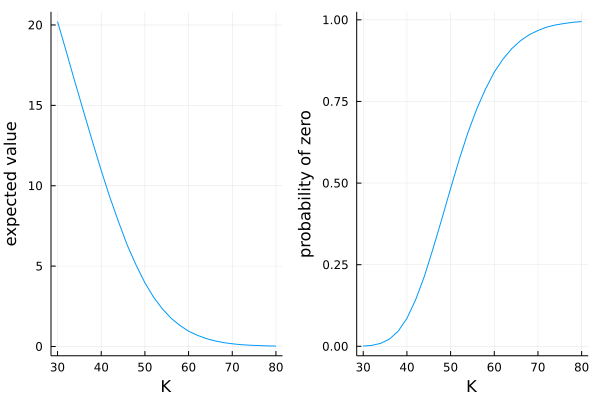

In [41]:
using Plots
plot(plot(df2.K, df2.mv; legend=false, xlabel="K", ylabel="expected value"),
     plot(df2.K, df2.zero; legend=false, xlabel="K", ylabel="probability of zero"))